In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import scvelo as scv
from pathlib import Path

# Paths and utils
root = Path('../')
figure_path = root / 'results/figures/Neutrophils/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
signatures_path = root / 'resources/'
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
data_path = Path(config['data_path'])
# local utils
sys.path.insert(1, '../utils/')
from utils import *

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
%matplotlib inline

In [2]:
# list files in data_path
list_files = list(data_path.glob('*.h5*'))
# print names
for i, file in enumerate(list_files):
    print(i, file.name)

0 LiaoZhang120520_data.h5
1 cov19_hamster_data.h5
2 MelmsIzar290421_data.h5
3 Pancov19_prepd_neutros.h5
4 cov19_dexa_hamster_data.h5
5 ChuaEils290620_data.h5
6 PhoRob_timecourse_all.h5
7 Cov19Hamster_timecourse_integrated_neutrophils.h5
8 Cov19Hamster_timecourse_integrated_all.h5
9 WendischSander241022_data.h5
10 Pancov19_prepd_all.h5
11 MesAur_timecourse_all.h5
12 Pancov19_prepd_endos.h5


In [3]:
superdata = sc.read(data_path / "Pancov19_prepd_all.h5")

# Import color options
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
celltype_colors = config['celltype_colors']
celltype_rough_colors = config['celltype_rough_colors']
organism_colors = config['organism_colors']
organism_dosage_colors = config['organism_dosage_colors']
dosage_colors = config['dosage_colors']

# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'$1\times10^4$ pfu',
    'high dose': r'$1\times10^5$ pfu'
}

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
            
    return s.replace('_', ', ')

from matplotlib.cm import get_cmap
# not super pretty, but ok for now
time_colors = {
    'D0': 'grey',
    'D2': get_cmap('viridis_r')(0),
    'D3': get_cmap('viridis_r')(1/3),
    'D5': get_cmap('viridis_r')(2/3),
    'E14': get_cmap('viridis_r')(0.99999999),
              }
    
# Translate color palettes to new names as well
Organism_colors = {sanitize_name(key) : value for key, value in config['organism_colors'].items()}
Organism_Dosage_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_colors'].items()}
Dosage_colors = {sanitize_name(key) : value for key, value in config['dosage_colors'].items()}
Time_colors = {sanitize_name(key) : value for key, value in time_colors.items()}

# define control dicts for DE testing etc.
control_dict = {x: ['pr_D0_Z1_L','pr_D0_Z2_L','pr_D0_Z3_L'] if 'pr' in x else ['ma_d0_lung_1', 'ma_d0_lung_2', 'ma_d0_lung_3'] for x in pd.unique(superdata.obs['orig.ident']) if '0' not in x}
control_dict_odt = {x: 'Dwarfhamster_no dose_D0' if 'Dwarfhamster' in x else 'Goldhamster_no dose_D0' for x in superdata.obs.organism_dosage_time.unique() if 'D0' not in x}

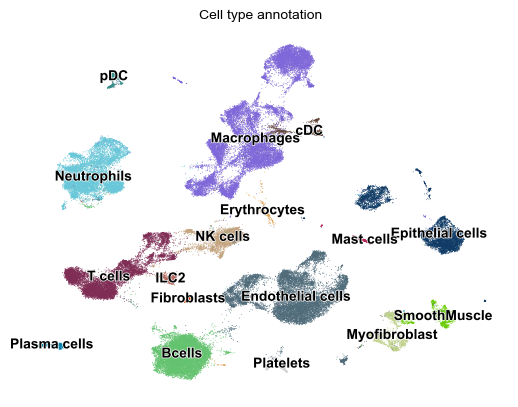

In [4]:
scv.pl.scatter(superdata, basis='umap_scVI', color='celltype_rough', legend_loc='on data', frameon=False, title='Cell type annotation', color_map=celltype_rough_colors)

# Rev3 14: Better GSEA reporting

Line 190. Why do the authors only report a couple of genes? Certainly, they did a pathway assessment and could define key genes in various canonical pathways - in the supplement would be fine. Also what are the top 10 genes in each group and do they cross reference?

# Rev1 Major 2: Th17 freq

Is the frequency of Th17 cells higher in the lungs of infected Roborovski hamsters compared to Syrian hamsters?

## Identify Th17 cells

In [13]:
tdata = superdata[superdata.obs['celltype_rough'] == 'T cells'].copy()
# recalculate neighbors and UMAP
sc.pp.neighbors(tdata, use_rep='X_scVI')
sc.tl.umap(tdata)

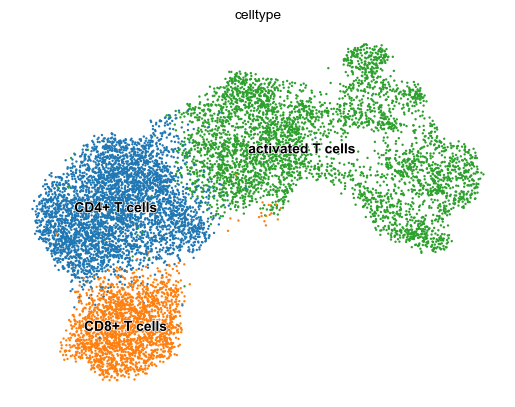

In [14]:
scv.pl.scatter(tdata, basis='umap', legend_loc='on data', frameon=False, color='celltype')

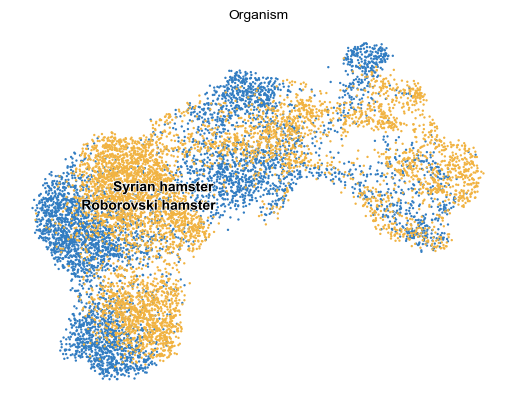

In [89]:
scv.pl.scatter(tdata, basis='umap', legend_loc='on data', frameon=False, color='Organism', color_map=Organism_colors)

In [77]:
markers =  ["Il17a", "Il17f", "Il21", "Il22", "Rorc", "Il6ra", "Il21r", "Il23r", "Stat3", "Ccr6"]
markers = list(np.intersect1d(markers, tdata.var_names))
good_markers = ['Ccr6', 'Il21r', 'Rorc', 'Stat3', 'Cd4', 'Cd8a', 'Cd8b', 'Socs1', 'Socs3', 'Tbx21', 'Gata3', 'Foxp3', 'Ccr4',
                'Ifng', 'Tnf',
                'Ccr5', 'Ccr1', 'Ccr2', 'Cxcr3', 'Ccr3'
                ]

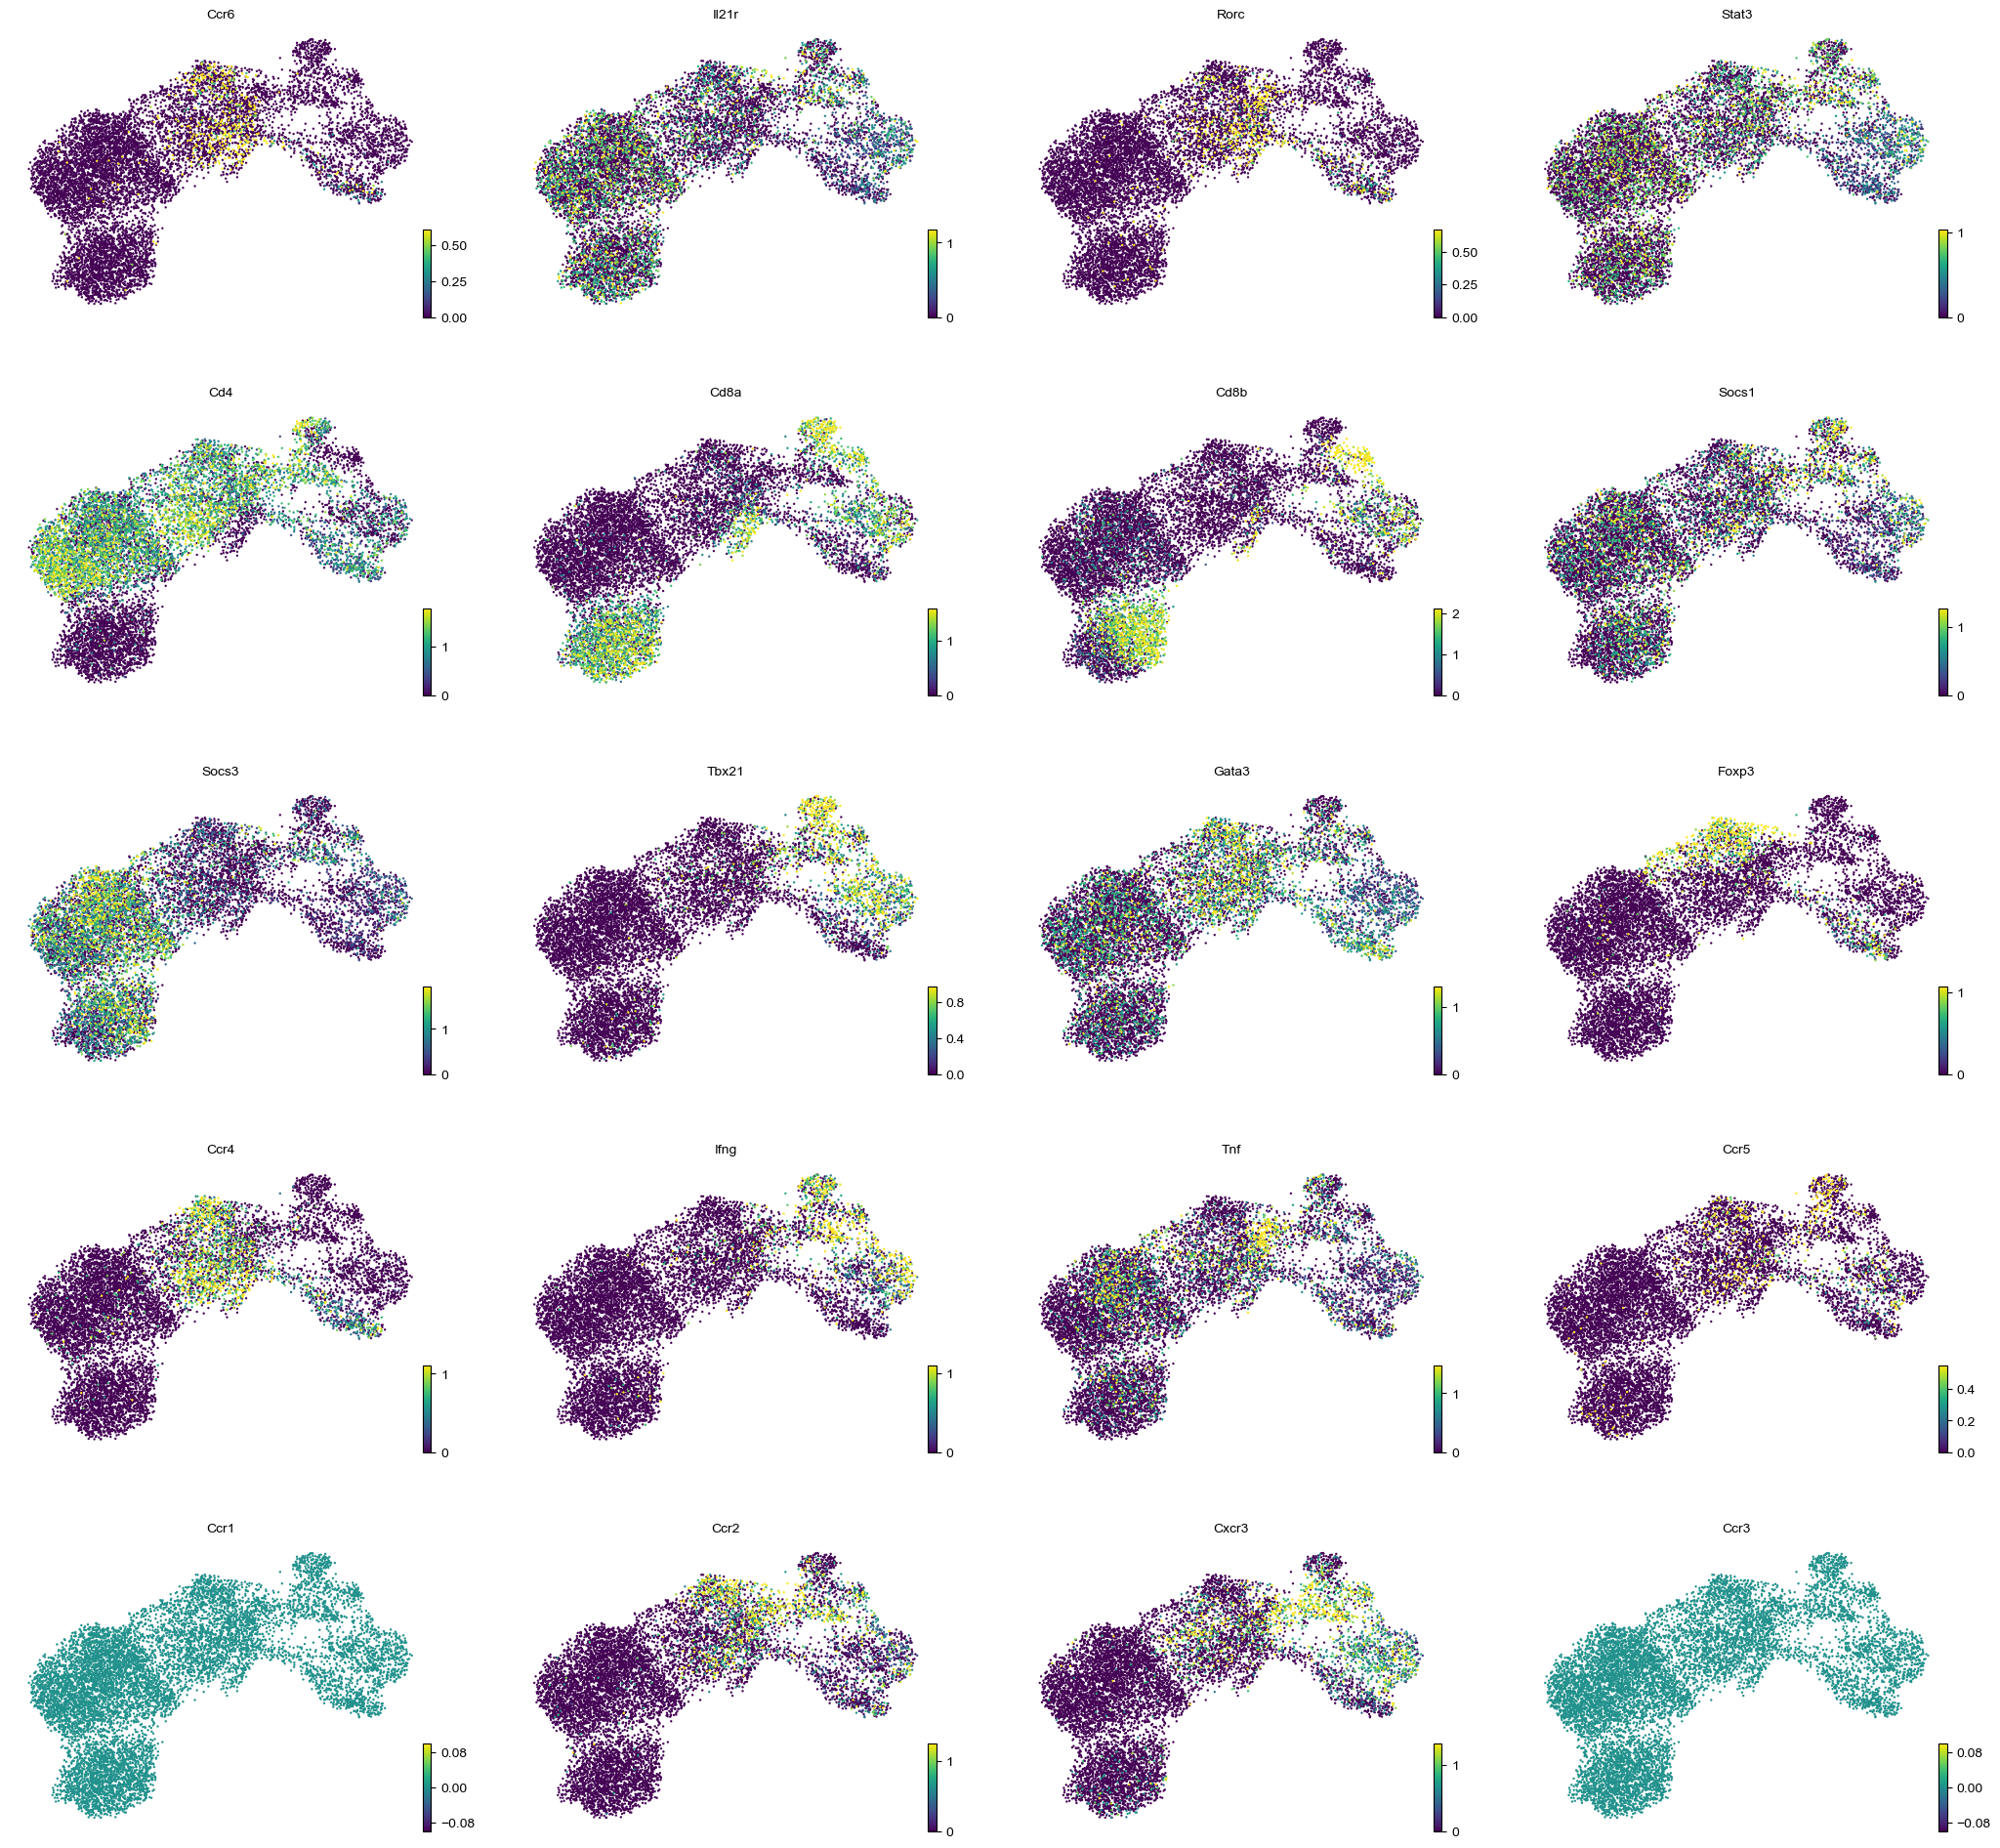

In [80]:
scv.pl.scatter(tdata, basis='umap', legend_loc='on data', frameon=False, color=good_markers, ncols=4, perc=[3, 97])

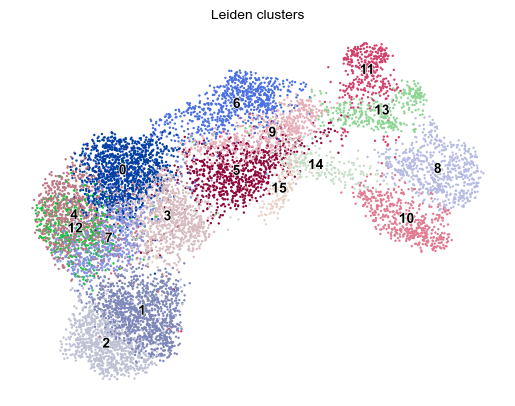

In [75]:
sc.tl.leiden(tdata, resolution=1.5)
scv.pl.scatter(tdata, basis='umap', legend_loc='on data', frameon=False, color='leiden', title='Leiden clusters', color_map='tab20')

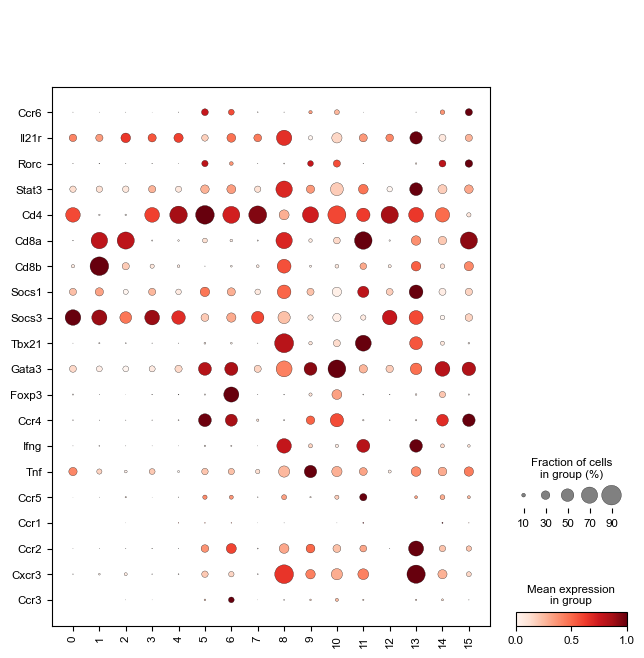

In [81]:
sc.pl.dotplot(tdata, good_markers, groupby='leiden', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True)

In [82]:
df = extract_df(tdata, ['leiden'] + good_markers)
sdf = df.groupby('leiden').mean()
sdf['Cd8'] = sdf[['Cd8a', 'Cd8b']].mean(axis=1)

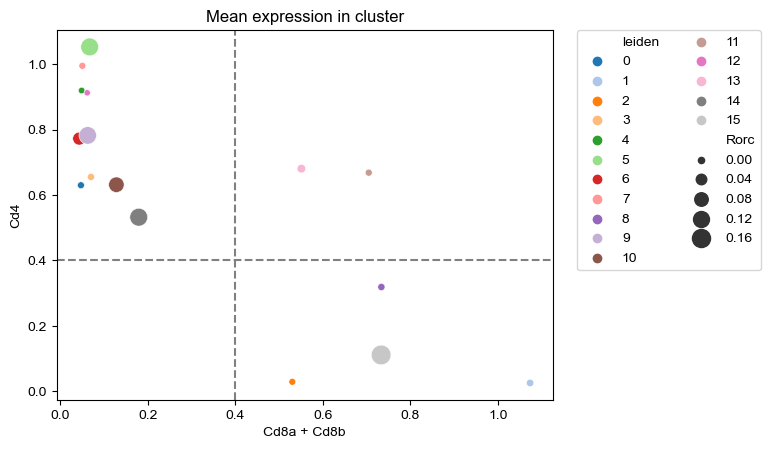

In [83]:
sns.scatterplot(data=sdf, x='Cd8', y='Cd4', hue=sdf.index, palette='tab20', size='Rorc', sizes=(20, 200))
pl.axvline(0.4, color='grey', linestyle='--')
pl.axhline(0.4, color='grey', linestyle='--')
pl.ylabel('Cd4')
pl.xlabel('Cd8a + Cd8b')
pl.title('Mean expression in cluster')
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)
pl.show()

In [84]:
types = {
    'CD4+CD8-': list(sdf[sdf['Cd8'] < 0.4].index),
    'CD4+CD8+': list(sdf[(sdf['Cd4'] > 0.4) & (sdf['Cd8'] > 0.4)].index),
    'CD4-CD8+': list(sdf[sdf['Cd4'] < 0.4].index)
}

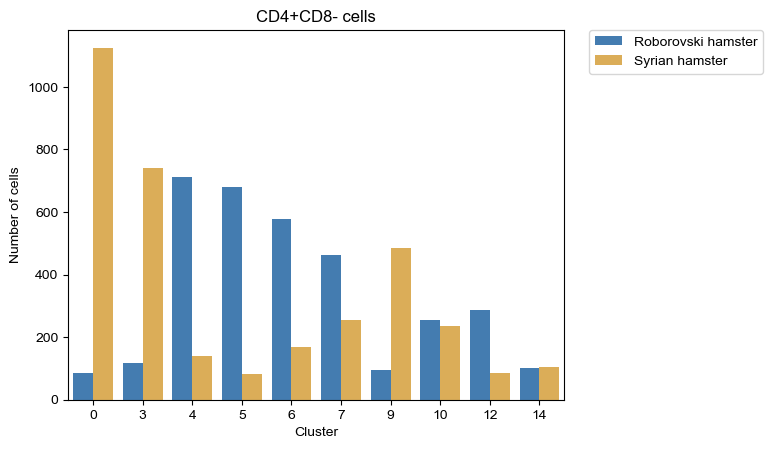

In [88]:
numbers = extract_df(tdata[tdata.obs.leiden.isin(types['CD4+CD8-'])], ['leiden', 'Organism']).value_counts(['leiden', 'Organism']).reset_index()
sns.barplot(data=numbers, x='leiden', y=0, hue='Organism', palette=Organism_colors)
pl.ylabel('Number of cells')
pl.xlabel('Cluster')
pl.title('CD4+CD8- cells')
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.show()

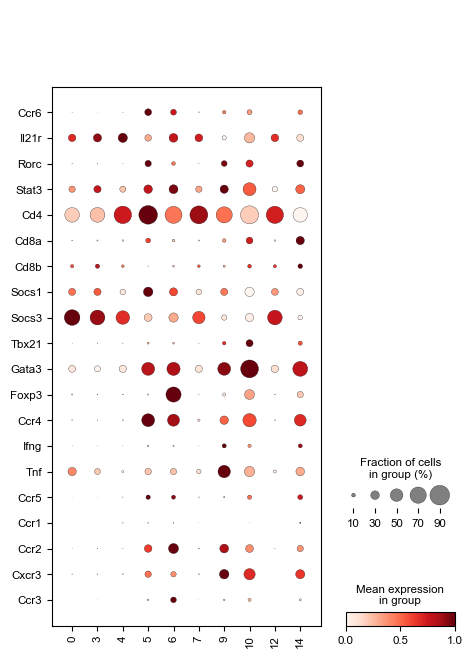

In [86]:
# We are looking for Rorc+ Foxp3- Ccr6+ cells
# Also good: Stat3+ Socs1+ Socs3-
data = tdata[tdata.obs.leiden.isin(types['CD4+CD8-'])]
sc.pl.dotplot(data, good_markers, groupby='leiden', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True)

>Geraldine: Du kannst ruhig alle RORc und CD4 CD3 positiven zusammenschmeissen (Cluster 5, 9, 14) Cluster 6 und 10 würde ich rauslassen, Cluster 15 scheinen CD8 zu sein, die RORc expremieren, die können wir auch rauslassen.
% TH17 / CD4 wäre die richtige Darstellung, FC nimmt man eigentlich nicht bei Zellpopulationen und passt hier ja auch nicht.

In [ ]:
# Cluster 6 are probably Tregs (Foxp3+)


## Compare Frequency of Th17 cells

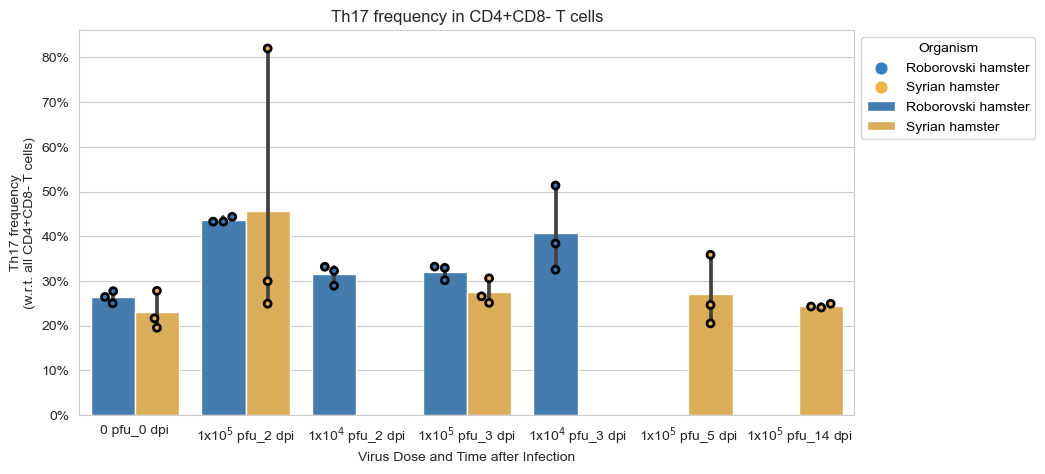

In [62]:
th17_cluster = ['5', '9', '10', '14']
# Calc Th17 frequency
df = extract_df(tdata[tdata.obs.leiden.isin(types['CD4+CD8-'])], ['leiden', 'Time', 'hamster', 'Organism', 'Dosage'])
df['subtype'] = 'CD4+CD8- T cells'
df['subtype'][df.leiden.isin(th17_cluster)] = 'Th17 cells'
counts = df.value_counts(['Time', 'hamster', 'Organism', 'Dosage', 'subtype'], sort=False).unstack(fill_value=0)
counts['Th17_frequency'] = (counts['Th17 cells'] / counts.sum(axis=1))
counts = counts.reset_index(drop=False)
counts['Dosage_Time'] = counts['Dosage'].astype(str) + '_' + counts['Time'].astype(str)

# Plot Th17 frequency
with sns.axes_style('whitegrid'):
    fig, ax= pl.subplots(figsize=(10, 5))
    sns.barplot(data=counts.reset_index(), x='Dosage_Time', y='Th17_frequency', hue='Organism', palette=Organism_colors)
    sns.swarmplot(data=counts.reset_index(), x='Dosage_Time', y='Th17_frequency', hue='Organism', palette=Organism_colors, edgecolor='k', linewidth=2, dodge=True, alpha=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.yaxis.set_major_formatter(pl.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Th17 frequency\n(w.r.t. all CD4+CD8- T cells)')
ax.set_xlabel('Virus Dose and Time after Infection')
pl.title('Th17 frequency in CD4+CD8- T cells')
pl.savefig("../results/figures/Revision/Rev1_Major2_Th17_frequency.pdf", bbox_inches='tight', dpi=300)
pl.show()

# Rev1 Major 3b: COV2 entry receptors

Additionally, it would be pertinent to discuss whether Sars-Cov2 entry receptors, like ACE2, CD147, AXL, TMPRSS2 and many others, are more prominently expressed in Roborovski hamster neutrophils compared to those in Syrian hamsters.

In [5]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10094153/
entry_receptors = [
    'Ace2', 'Tmprss2', 'Ctsl', 'Nrp1', # main entry factors
    'Bsg', # Cd147
    'Axl', 'Kremen1'
]
# not found: 'Cd209', 'Havcr1' aka Tim1
# Expression too low:  'Asgr1', 'Clec4g' 

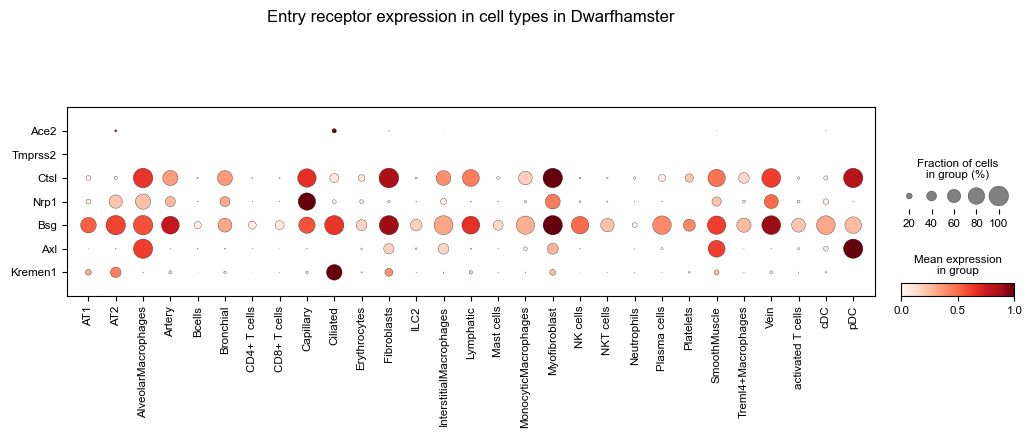

In [6]:
sc.pl.dotplot(superdata[superdata.obs.organism=='Dwarfhamster'], 
              entry_receptors, groupby='celltype', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True,
              title='Entry receptor expression in cell types in Dwarfhamster')

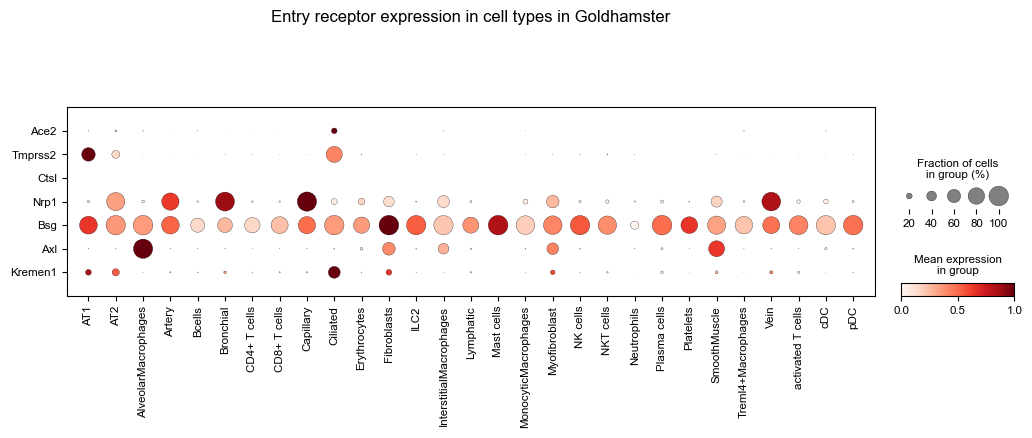

In [7]:
sc.pl.dotplot(superdata[superdata.obs.organism=='Goldhamster'], 
              entry_receptors, groupby='celltype', use_raw=False, dendrogram=False, standard_scale='var', swap_axes=True,
              title='Entry receptor expression in cell types in Goldhamster')

In [8]:
percent_expressings = {}
mean_expressions = {}
for Organism in ['Roborovski hamster', 'Syrian hamster']:
    df = extract_df(superdata[superdata.obs.Organism==Organism], ['celltype'] + entry_receptors)
    # this is black magic here
    df.set_index('celltype', inplace=True)
    percent_expressing = pd.concat(
        {gene: (df > 0).value_counts(['celltype', gene], normalize=False, sort=False).loc[:, True].reindex(sorted(df.index.unique()), fill_value=0) \
            / df.value_counts(['celltype'], sort=False).reset_index().set_index('celltype')[0] \
            for gene in entry_receptors if df[gene].sum()>0}, axis=1
    ).fillna(0).T * 100
    percent_expressing.columns = percent_expressing.columns.astype(str)
    percent_expressing.sort_index(axis=1, inplace=True)

    df = extract_df(superdata[superdata.obs.Organism==Organism], ['celltype'] + entry_receptors)
    mean_expression = df.groupby('celltype').mean().T
    mean_expression.columns = mean_expression.columns.astype(str)
    mean_expression.sort_index(axis=1, inplace=True)
    
    percent_expressings[Organism] = percent_expressing
    mean_expressions[Organism] = mean_expression

In [9]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Wedge
def split_dotplot(color_df1, size_df1, color_df2, size_df2, figsize=None, ax=None, dpi=None, title=None, show=True, cmap='Reds'):
    if ax is None:
            fig, ax = fig, ax = pl.subplots(figsize=figsize, dpi=dpi)
    for side, color_df, size_df in zip(['left', 'right'], [color_df1, color_df2], [size_df1, size_df2]):
        N, M = color_df.shape

        x, y = np.meshgrid(np.arange(M), np.arange(N))
        s = size_df.values.astype(int)  # TODO
        c = color_df.values.astype(float)  # TODO

        max_radius = 0.8
        R = s/s.max()/2 * max_radius
        if side == 'left':
            circles = [Wedge((j,i), r, 90, 270) for r, j, i in zip(R.flat, x.flat, y.flat)]
        else:
            circles = [Wedge((j,i), r, 270, 90) for r, j, i in zip(R.flat, x.flat, y.flat)]
        col = PatchCollection(circles, array=c.flatten(), cmap=cmap, edgecolors='k', linewidths=1, alpha=0.8)
        ax.add_collection(col)
        
    # set ticks and labels
    ylabels = color_df.index
    xlabels = color_df.columns
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
            xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_xticklabels(xlabels, rotation=45, ha='right')
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.set_yticklabels(ylabels)
    
    ax.grid(which='minor')
    ax.set_aspect('equal')
    if title is not None:ax.set_title(title)
    fig.colorbar(col, ax=ax, label='NES', pad=0.05, aspect=10, shrink=0.25)  # TODO
    if show: pl.show()

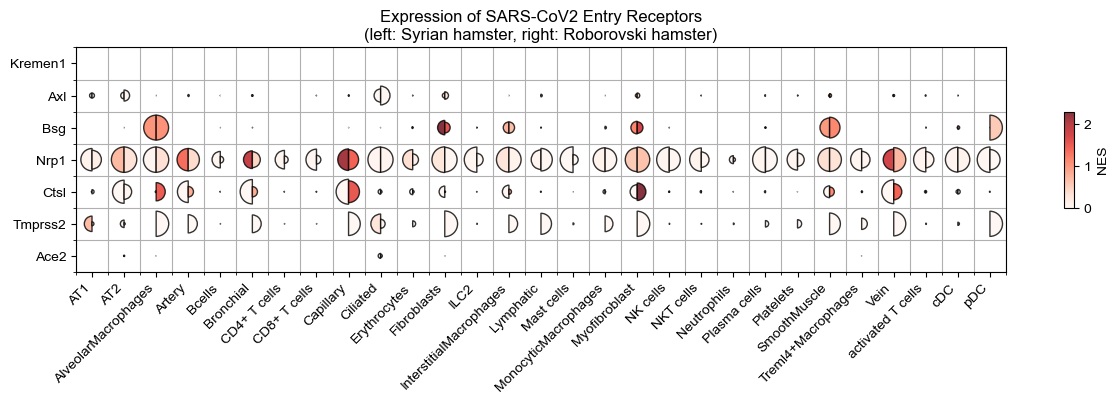

In [10]:
split_dotplot(mean_expressions['Syrian hamster'], percent_expressings['Syrian hamster'], 
              mean_expressions['Roborovski hamster'], percent_expressings['Roborovski hamster'], 
              figsize=(15,5), ax=None, dpi=None, title="Expression of SARS-CoV2 Entry Receptors\n(left: Syrian hamster, right: Roborovski hamster)", 
              show=False)
pl.savefig("../results/figures/Revision/Rev1_Major3b_Entry_receptor_expression_splitdots.pdf", bbox_inches='tight', dpi=300)
pl.show()

In [55]:
# only neutros
neutros = superdata[superdata.obs.celltype=='Neutrophils'].copy()
df = extract_df(neutros, ['Time', 'replicate', 'Organism', 'Dosage']+ entry_receptors)

In [56]:
# cell-wise expression
cdf = df.set_index(['Time', 'replicate', 'Organism', 'Dosage']).stack().reset_index().rename(columns={'level_4': 'gene', 0: 'expression'})
# sample-wise mean expression
sdf = df.groupby(['Time', 'replicate', 'Organism', 'Dosage']).mean().stack().reset_index().rename(columns={'level_4': 'gene', 0: 'expression'})

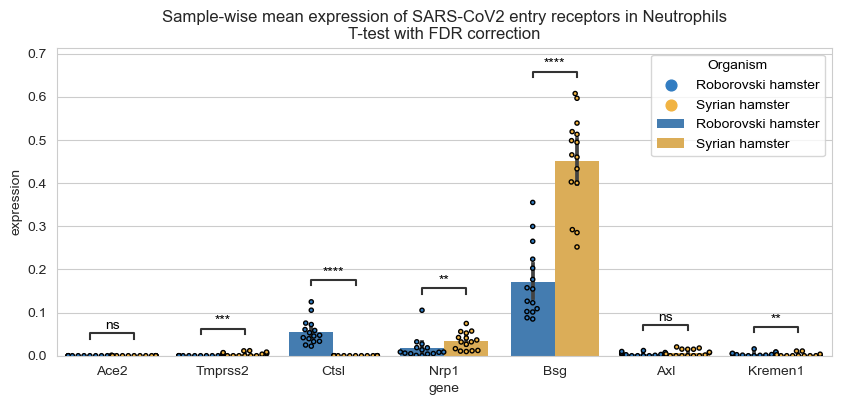

In [89]:
from statannotations.Annotator import Annotator
with sns.axes_style('whitegrid'):
    fig, ax= pl.subplots(figsize=(10, 4))
sns.barplot(data=sdf, hue='Organism', y='expression', x='gene', palette=Organism_colors)
sns.swarmplot(data=sdf, hue='Organism', y='expression', x='gene', palette=Organism_colors, edgecolor='k', linewidth=1, dodge=True, alpha=1, size=3)
pl.title('Sample-wise mean expression of SARS-CoV2 entry receptors in Neutrophils\nT-test with FDR correction')

pairs=[((gene, "Roborovski hamster"), (gene, "Syrian hamster")) for gene in entry_receptors]
annotator = Annotator(ax, pairs, data=sdf, hue='Organism', y='expression', x='gene', verbose=0)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='fdr_bh', verbose=0)
annotator.apply_and_annotate()

pl.show()

In [71]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind
# test between Organisms
pseudo_bulk = df.groupby(['Organism', 'Time', 'Dosage', 'replicate']).mean().dropna().reset_index()
pvals = []
for gene in entry_receptors:
    a = pseudo_bulk[(pseudo_bulk.Organism=='Syrian hamster')][gene]
    b = pseudo_bulk[(pseudo_bulk.Organism=='Roborovski hamster')][gene]
    pvals.append([gene, ttest_ind(a, b, equal_var=False).pvalue])
corrected = multipletests([x[1] for x in pvals], method='fdr_bh')[1]
res = pd.DataFrame(pvals, columns=['gene', 'pval'])
res['adj_pval'] = corrected

# Rev1 Minor 2: Ribo RNA and damage

Line 252: in scRNAseq experiments, increased expression of ribosomal RNA is sometimes associated with damaged cells. This point should be discussed.

In [9]:
superdata.var_names.str.startswith('Rps').sum(), superdata.var_names.str.startswith('Rpl').sum()

(44, 49)

In [10]:
is_ribo = np.logical_or(superdata.var_names.str.startswith('Rps'), superdata.var_names.str.startswith('Rpl'))
superdata.obs['percent_ribo'] = superdata[:, is_ribo].layers['counts'].sum(1).A1 / superdata.layers['counts'].sum(1).A1 * 100

<Axes: >

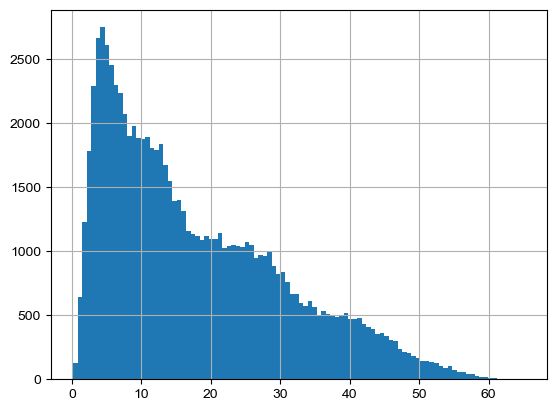

In [11]:
superdata.obs['percent_ribo'].hist(bins=100)

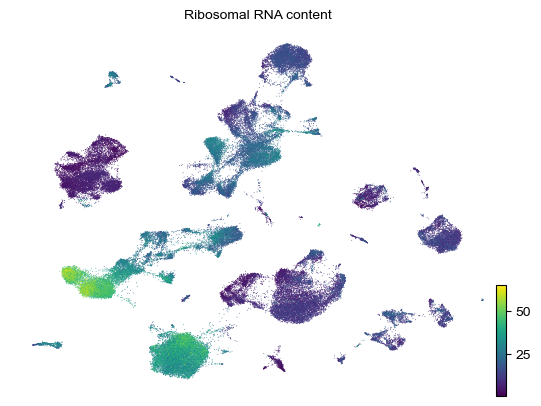

In [12]:
scv.pl.scatter(superdata, basis='umap_scVI', color='percent_ribo', frameon=False, title='Ribosomal RNA content', color_map='viridis', show=False)
pl.savefig("../results/figures/Revision/Rev1_Minor2_ribo_umap.png", bbox_inches='tight', dpi=300)
pl.show()

In [13]:
df = extract_df(superdata, ['celltype', 'Organism', 'Dosage', 'Time', 'replicate', 'percent_ribo'])
df = df[df.celltype.isin(['Neutrophils', 'Artery', 'Vein', 'Bronchial', 'Capillary'])]
df.celltype = df.celltype.astype('str')
ribo_means = df.groupby(['celltype', 'Dosage', 'Time', 'Organism', 'replicate']).mean().reset_index()

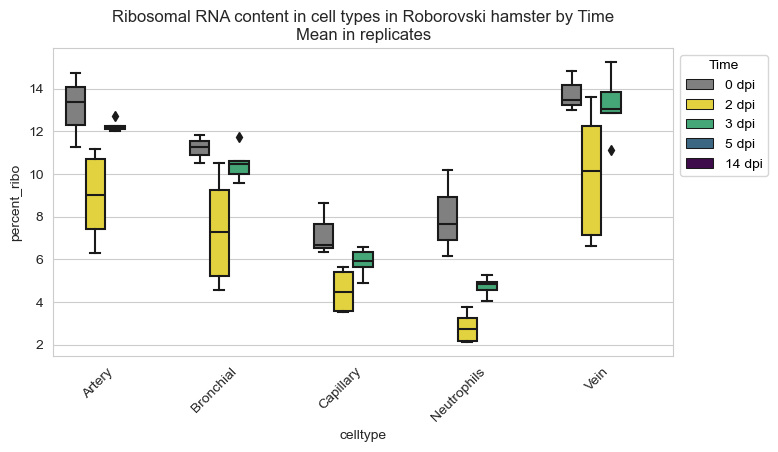

In [14]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8, 4))
data = ribo_means[ribo_means.Organism == "Roborovski hamster"]
data.Time.cat.remove_unused_categories(inplace=True)
sns.boxplot(data=data, x='celltype', y='percent_ribo', hue='Time', palette=Time_colors)
pl.xticks(rotation=45, ha='right')
pl.title('Ribosomal RNA content in cell types in Roborovski hamster by Time\nMean in replicates')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
pl.show()

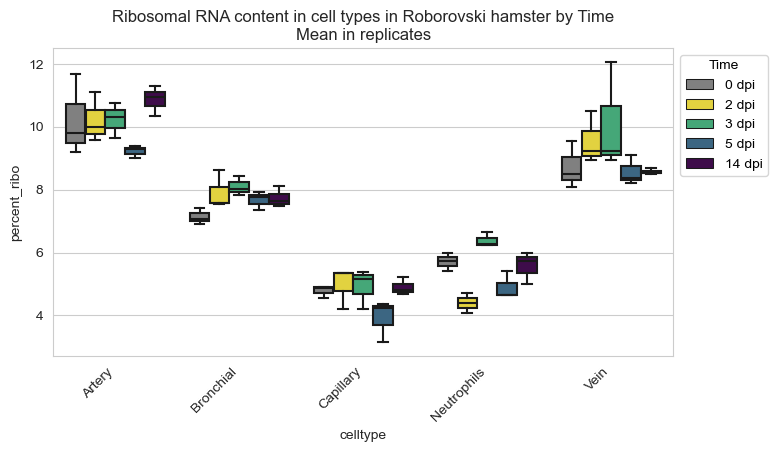

In [19]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8, 4))
data = ribo_means[ribo_means.Organism != "Roborovski hamster"]
data.Time.cat.remove_unused_categories(inplace=True)
sns.boxplot(data=data, x='celltype', y='percent_ribo', hue='Time', palette=Time_colors)
pl.xticks(rotation=45, ha='right')
pl.title('Ribosomal RNA content in cell types in Roborovski hamster by Time\nMean in replicates')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
pl.show()

In [15]:
# Foldchange w.r.t. Time 0 dpi
baseline_mean = ribo_means[ribo_means.Time=='0 dpi'].groupby(['celltype', 'Organism']).mean().percent_ribo
ribos = ribo_means.set_index(['celltype', 'Organism', 'Dosage', 'Time', 'replicate']).dropna()
fcs = {}
for celltype in ribos.index.levels[0].unique():
    for organism in ribos.index.levels[1].unique():
        fcs[(celltype, organism)] = ribos.loc[celltype, organism].percent_ribo / baseline_mean[celltype, organism]
res = pd.concat(fcs, axis=0).reset_index().rename(columns={'level_0': 'celltype', 'level_1': 'Organism', 'percent_ribo': 'Foldchange'})
res['l2fc'] = np.log2(res.Foldchange)

In [16]:
res.head()

celltype            Organism        Dosage   Time replicate  Foldchange  \
0   Artery  Roborovski hamster         0 pfu  0 dpi         1    1.123511   
1   Artery  Roborovski hamster         0 pfu  0 dpi         2    1.019572   
2   Artery  Roborovski hamster         0 pfu  0 dpi         3    0.856918   
3   Artery  Roborovski hamster  1x10$^4$ pfu  2 dpi         1    0.733770   
4   Artery  Roborovski hamster  1x10$^4$ pfu  2 dpi         2    0.842067   

       l2fc  
0  0.168014  
1  0.027963  
2 -0.222772  
3 -0.446600  
4 -0.247994

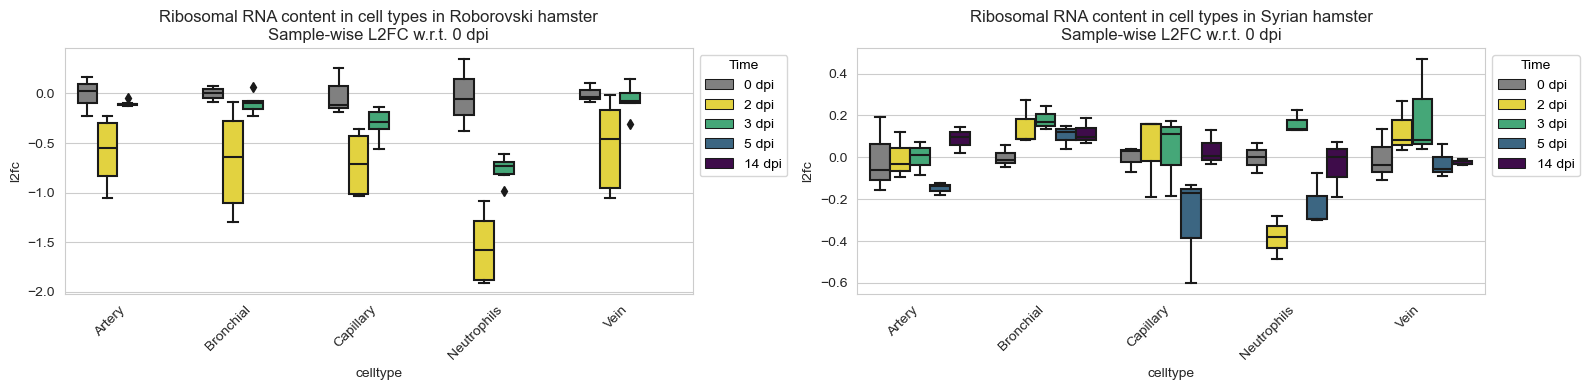

In [17]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1,2, figsize=(8*2, 4))
for Organism in ['Roborovski hamster', 'Syrian hamster']:
    ax = axs[0] if Organism == 'Roborovski hamster' else axs[1]
    data = res[res.Organism == Organism]
    sns.boxplot(data=data, x='celltype', y='l2fc', hue='Time', palette=Time_colors, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f'Ribosomal RNA content in cell types in {Organism}\nSample-wise L2FC w.r.t. 0 dpi')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
pl.tight_layout()
pl.savefig("../results/figures/Revision/Rev1_Minor2_ribo_content_foldchange.pdf", bbox_inches='tight', dpi=300)
pl.show()

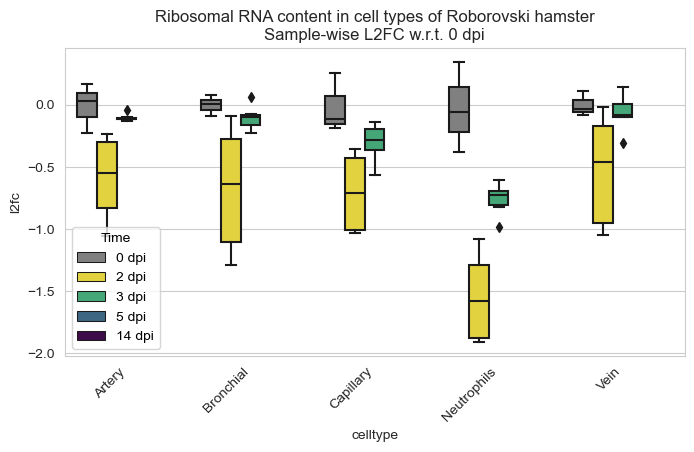

In [18]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8, 4))
sns.boxplot(data=res[res.Organism != 'Syrian hamster'], x='celltype', y='l2fc', hue='Time', palette=Time_colors)
pl.xticks(rotation=45, ha='right')
pl.title('Ribosomal RNA content in cell types of Roborovski hamster\nSample-wise L2FC w.r.t. 0 dpi')
pl.show()

# Rev1 Major 3a: Virus RNA distribution

In Supplementary Figure 1D, there appears to be a higher presence of Sars-Cov2 RNA in neutrophils from Roborovski hamsters compared to those from Syrian hamsters. An exploration of how Sars-Cov2 RNA is distributed among various cell types would provide valuable insights and should be addressed.

In [5]:
df = extract_df(superdata, ['celltype', 'Organism', 'Dosage', 'Time', 'replicate', 'SCoV2_sum', 'SCoV2_load', 'SCoV2_detected'])
df.SCoV2_detected = df.SCoV2_detected.astype('int')

In [6]:
# mean per celltype
sdf = df.groupby(['celltype', 'Organism', 'Dosage', 'Time', 'replicate']).mean().dropna().reset_index()
sdf = sdf[sdf.Time != '0 dpi']
sdf = sdf[sdf.Time != '14 dpi']
sdf = sdf[sdf.Dosage != '1x10$^4$ pfu']

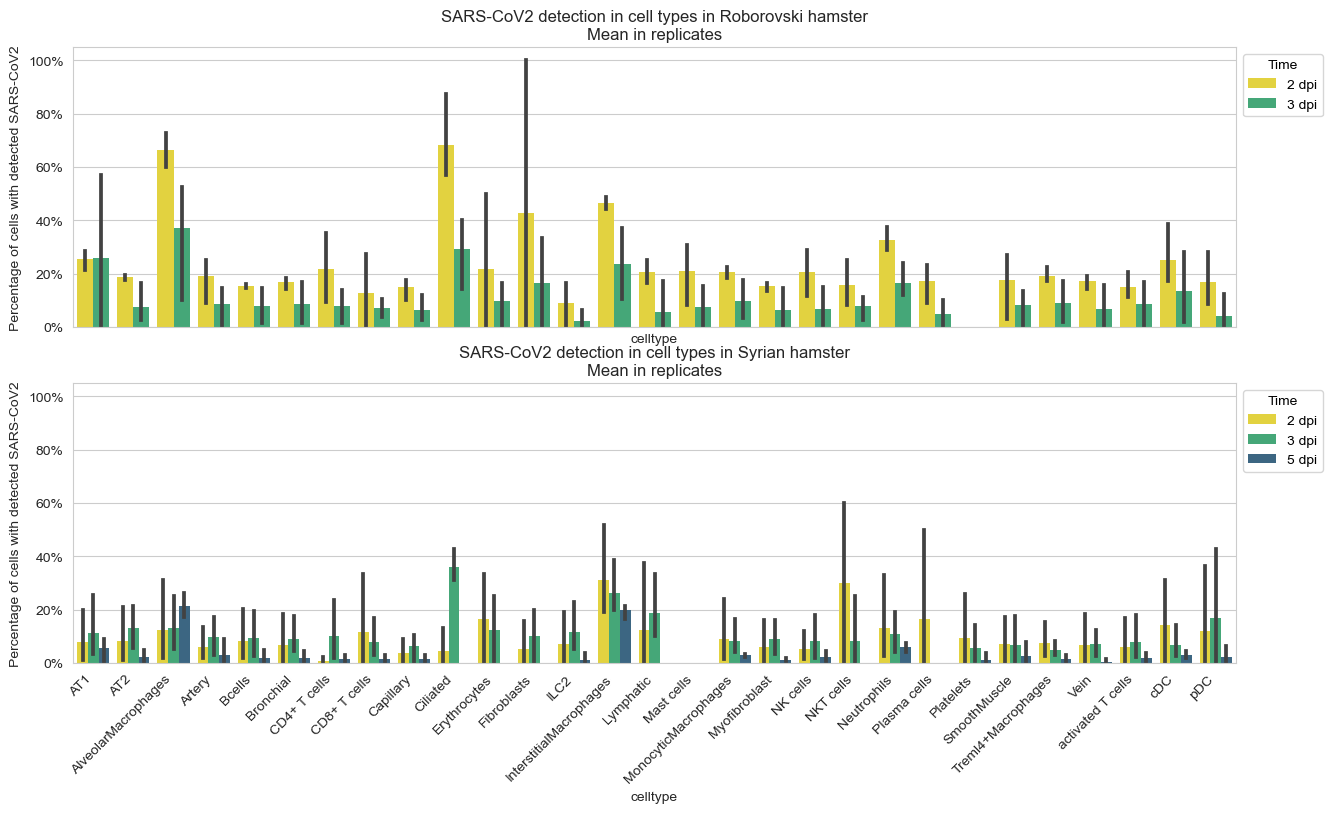

In [7]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 1, figsize=(15, 4*2), sharex=True, sharey=True)
for Organism in ['Roborovski hamster', 'Syrian hamster']:
    ax = axs[0] if Organism == 'Roborovski hamster' else axs[1]
    data = sdf[sdf.Organism == Organism]
    data.Time.cat.remove_unused_categories(inplace=True)
    sns.barplot(data=data, x='celltype', y='SCoV2_detected', hue='Time', palette=Time_colors, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f'SARS-CoV2 detection in cell types in {Organism}\nMean in replicates')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_ylabel('Percentage of cells with detected SARS-CoV2')
    ax.yaxis.set_major_formatter(pl.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pl.savefig("../results/figures/Revision/Rev1_Major3a_SCoV2_detection_barplot.pdf", bbox_inches='tight', dpi=300)
pl.show()

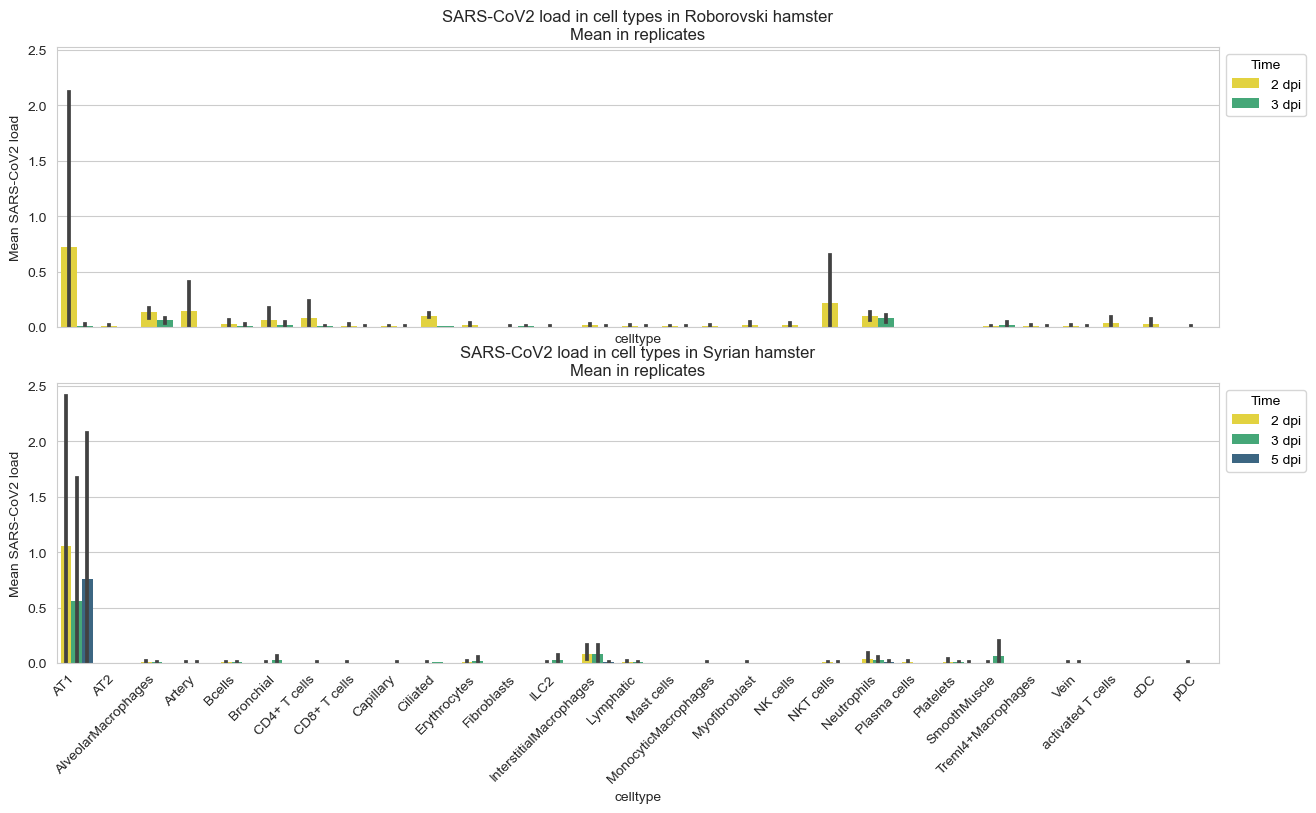

In [8]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 1, figsize=(15, 4*2), sharex=True, sharey=True)
for Organism in ['Roborovski hamster', 'Syrian hamster']:
    ax = axs[0] if Organism == 'Roborovski hamster' else axs[1]
    data = sdf[sdf.Organism == Organism]
    data.Time.cat.remove_unused_categories(inplace=True)
    sns.barplot(data=data, x='celltype', y='SCoV2_load', hue='Time', palette=Time_colors, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f'SARS-CoV2 load in cell types in {Organism}\nMean in replicates')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_ylabel('Mean SARS-CoV2 load')
pl.savefig("../results/figures/Revision/Rev1_Major3a_SCoV2_load_barplot.pdf", bbox_inches='tight', dpi=300)
pl.show()

# Rev2 2b: Baseline gene sets

In [49]:
nulldata_r = superdata[(superdata.obs.Organism=='Roborovski hamster') & (superdata.obs.Time=='0 dpi')].copy()
sc.pp.filter_genes(nulldata_r, min_cells=10)
nulldata_s = superdata[(superdata.obs.Organism=='Syrian hamster') & (superdata.obs.Time=='0 dpi')].copy()
sc.pp.filter_genes(nulldata_s, min_cells=10)

In [50]:
# now do ORA?
from gseapy import enrichr
def gseapy_enrichr(gene_list, background, species='human',
                  gene_sets=None, enrichr_lib_path=None,
                  description='pathway', cutoff=1, min_genes=1, **kwargs):
    '''
    Internally makes all genes human because enrichr handles it that way in their libs it seems.
    Background can be a integer number or a list of gene names.
    '''
    enrichr_lib_path = Path('/Users/peidli/work/utils/scRNAseq_signature_collection/enrichr_libraries/') if enrichr_lib_path is None else enrichr_lib_path
    if species == 'human' and gene_sets==None:
        gene_sets = [enrichr_lib_path / f'{key}.gmt' for key in ['KEGG_2022_Human', 'ReactomePathways_2022_Human', 'MSigDB_Hallmark_2022_Human']]
    elif species == 'mouse' and gene_sets==None:
        gene_sets = [enrichr_lib_path / f'{key}.gmt' for key in ['ReactomePathways_2022_Mouse', 'MSigDB_Hallmark_2022_Mouse']]  # TODO KEGG_2019_Mouse is human all caps!!!
    gene_sets = [x.as_posix() for x in gene_sets]
    background = background if type(background)==int else specify_genes(background, 'human')  # always make background human
    if type(gene_list) == pd.core.indexes.base.Index:
        gene_list = list(gene_list)

    results=enrichr(
        gene_list=specify_genes(gene_list, species),
        gene_sets=gene_sets,
        cutoff=1,   # leave this cutoff at 1!!!
        background=background, **kwargs
        )
    res = results.results
    if len(res)==0:
        print('No hits found during GOEA.')
    else:
        res = res[res['Adjusted P-value'] < cutoff].sort_values('Adjusted P-value', ascending=True)
        res['members'] = [int(x.split('/')[0]) for x in res.Overlap]
        res = res[res['members'] >= min_genes]
        res = res.reset_index(drop=True)#.drop(['Old P-value', 'Old Adjusted P-value'], axis=1)
        return res

In [51]:
sc.pp.highly_variable_genes(nulldata_s, n_top_genes=2000, batch_key='celltype', flavor='seurat_v3', layer='counts', span=1)

ZeroDivisionError: division by zero

In [41]:
mask = (nulldata_s.var.highly_variable)# & (nulldata_r.var.highly_variable_nbatches > 6)
genes = list(nulldata_s.var_names[mask])
background = nulldata_s.var_names[nulldata_s.X.sum(0).A1 > 50]
res = gseapy_enrichr(genes, 
               background, 
               species='human',
               cutoff=0.05,
               min_genes=10
               )

In [32]:
res

Gene_set                                               Term  \
0    CUSTOM20322520448         REACTOME_EUKARYOTIC_TRANSLATION_ELONGATION   
1    CUSTOM11967650944                                      KEGG_RIBOSOME   
2    CUSTOM20322520448  REACTOME_RESPONSE_OF_EIF2AK4_GCN2_TO_AMINO_ACI...   
3    CUSTOM20322520448         REACTOME_EUKARYOTIC_TRANSLATION_INITIATION   
4    CUSTOM20322520448               REACTOME_SELENOAMINO_ACID_METABOLISM   
..                 ...                                                ...   
123  CUSTOM20322520448                     REACTOME_BIOLOGICAL_OXIDATIONS   
124  CUSTOM20322520704                     HALLMARK_XENOBIOTIC_METABOLISM   
125  CUSTOM20322520448  REACTOME_SIGNALING_BY_RHO_GTPASES_MIRO_GTPASES...   
126  CUSTOM20322520448          REACTOME_SIGNALING_BY_TGFB_FAMILY_MEMBERS   
127  CUSTOM20322520448  REACTOME_TRANSCRIPTIONAL_REGULATION_OF_GRANULO...   

    Overlap       P-value  Adjusted P-value  Odds Ratio  \
0     58/81  3.341052e-31      4.299934e-28    5.089862   
1     55/76  4.896094e-30      8.029594e-28    5.136269   
2     58/87  1.452601e-28      9.347488e-26    4.738056   
3    61/105  3.428499e-25      1.103119e-22    4.132512   
4     57/93  2.746243e-25      1.103119e-22    4.352627   
..      ...           ...               ...         ...   
123   22/83  3.076882e-03      3.882301e-02    1.863765   
124  27/125  2.080670e-02      4.161340e-02    1.514493   
125  94/496  3.454264e-03      4.274651e-02    1.327987   
126   23/89  3.554825e-03      4.357200e-02    1.816264   
127   11/32  4.052563e-03      4.874438e-02    2.441455   

                                                 Genes  members  
0    RPL3;RPS15;RPL28;RPS3A;RPS18;EEF1B2;RPS11;RPL3...       58  
1    RPS15;RPL3;RPL28;RPS18;RPS11;RPL35;RPS12;RPL8;...       55  
2    RPL3;RPS15;RPL28;RPS3A;RPS18;RPS11;RPL35;RPS12...       58  
3    RPL3;RPS15;EIF2B2;RPL28;RPS3A;RPS18;RPS11;RPL3...       61  
4    RPL3;RPS15;RPL28;RPS3A;RPS18;RPS11;RPL35;RPS12...       57  
..                                                 ...      ...  
123  FMO2;ALDH1A1;AOC3;CBR3;AIP;GSTM1;CYP4B1;CYP1A1...       22  
124  IGFBP4;RBP4;TMEM176B;ALAS1;MT2A;IRF8;ID2;ARG1;...       27  
125  NCF1;ARHGAP28;TUBA1B;ACTB;ZWILCH;SOWAHC;RACGAP...       94  
126  BMP2;JUNB;PPP1CB;ITGB5;GREM2;TGFB3;MYC;COL1A2;...       23  
127  MYC;H2AX;CEBPA;CEBPB;H3C14;H2BC3;DEK;CEBPE;TFD...       11  

[128 rows x 8 columns]

In [34]:
# well, shit
res[res['Term'].str.contains('INFLAMMATORY')]

Gene_set                            Term Overlap       P-value  \
36  CUSTOM20322520704  HALLMARK_INFLAMMATORY_RESPONSE  47/141  1.315830e-08   

    Adjusted P-value  Odds Ratio  \
36      8.223936e-08    2.348435   

                                                Genes  members  
36  IL1B;CD14;C5AR1;CD40;CD69;RGS1;CSF3R;LTA;IFITM...       47

In [53]:
# pseudo-bulk the control samples, then do ORA on top std genes
from itertools import product
from tqdm.auto import tqdm
def pseudo_bulk(adata, keys, layer='counts', min_cells_per_group=1, dtype=int):
    """
    Pseudo-bulk count data from adata grouped by one or multiple keys.
    
    Parameters
    ----------
    adata: AnnData
        Annotated data matrix.
    keys: str or list of str
        Keys to group by.
    layer: str or None
        Layer to use. If None, uses adata.X.
    min_cells_per_group: int
        Minimum number of cells per group to be included. Per default all non-empty groups are included.
    dtype: type
        Data type of the returned matrix. Per default int. Set to float if you want to use non-integer data.

    Returns
    -------
    sc.AnnData
        Pseudo-bulk data.
    """
    
    X = []
    Y = []
    for gs in tqdm(product(*[pd.unique(adata.obs[key]) for key in keys])):
        mask = np.logical_and.reduce([adata.obs[key]==g for g, key in zip(gs, keys)])  # select cells
        ncells = sum(mask)
        if ncells < min_cells_per_group: continue
        Y.append(list(gs)+[ncells])
        X_ = adata[mask].layers[layer] if layer!=None else adata[mask].X  # select data
        X.append(np.array(np.sum(X_, axis=0), dtype=dtype)[0])  # sum over cells
    obs=pd.DataFrame(Y, columns=list(keys)+['ncells'])
    return sc.AnnData(np.array(X), obs=obs, var=adata.var)

In [73]:
pdata = pseudo_bulk(nulldata_s, ['replicate'], layer='counts', min_cells_per_group=1, dtype=int)
pdata.var['std'] = np.std(pdata.X, axis=0)
pdata.var['mean'] = np.mean(pdata.X, axis=0)

0it [00:00, ?it/s]

In [71]:
genes = list(pdata.var['std'].sort_values(ascending=False).index)[:100]
background = nulldata_s.var_names[nulldata_s.X.sum(0).A1 > 50]
res = gseapy_enrichr(genes, 
               background, 
               species='human',
               cutoff=0.05,
               min_genes=10
               )

In [72]:
res

Gene_set                                               Term  \
0   CUSTOM20362470080         REACTOME_EUKARYOTIC_TRANSLATION_ELONGATION   
1   CUSTOM20365526016                                      KEGG_RIBOSOME   
2   CUSTOM20362470080  REACTOME_RESPONSE_OF_EIF2AK4_GCN2_TO_AMINO_ACI...   
3   CUSTOM20362470080               REACTOME_SELENOAMINO_ACID_METABOLISM   
4   CUSTOM20362470080  REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN...   
5   CUSTOM20362470080               REACTOME_NONSENSE_MEDIATED_DECAY_NMD   
6   CUSTOM20362470080         REACTOME_EUKARYOTIC_TRANSLATION_INITIATION   
7   CUSTOM20362470080           REACTOME_CELLULAR_RESPONSE_TO_STARVATION   
8   CUSTOM20362470080                       REACTOME_INFLUENZA_INFECTION   
9   CUSTOM20362470080  REACTOME_REGULATION_OF_EXPRESSION_OF_SLITS_AND...   
10  CUSTOM20362470080               REACTOME_SIGNALING_BY_ROBO_RECEPTORS   
11  CUSTOM20362470080                           REACTOME_RRNA_PROCESSING   
12  CUSTOM20362470080                               REACTOME_TRANSLATION   
13  CUSTOM20362470080  REACTOME_METABOLISM_OF_AMINO_ACIDS_AND_DERIVAT...   
14  CUSTOM20362470080                REACTOME_NERVOUS_SYSTEM_DEVELOPMENT   
15  CUSTOM20362470080             REACTOME_CELLULAR_RESPONSES_TO_STIMULI   
16  CUSTOM20362470080                     REACTOME_DEVELOPMENTAL_BIOLOGY   
17  CUSTOM20362470080  REACTOME_SARS_COV_2_MODULATES_HOST_TRANSLATION...   
18  CUSTOM20362470080                        REACTOME_INFECTIOUS_DISEASE   
19  CUSTOM20362470080                         REACTOME_METABOLISM_OF_RNA   
20  CUSTOM20362470080  REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_O...   
21  CUSTOM20362470080              REACTOME_SARS_COV_2_HOST_INTERACTIONS   
22  CUSTOM20362470080                      REACTOME_SARS_COV_2_INFECTION   
23  CUSTOM20362470080                       REACTOME_SARS_COV_INFECTIONS   
24  CUSTOM20362469760                            HALLMARK_MYC_TARGETS_V1   
25  CUSTOM20362470080                  REACTOME_NEUTROPHIL_DEGRANULATION   
26  CUSTOM20362470080                      REACTOME_INNATE_IMMUNE_SYSTEM   

   Overlap        P-value  Adjusted P-value  Odds Ratio  \
0    54/85  6.711072e-100      2.865628e-97  180.282148   
1    52/81   2.839345e-96      7.098361e-95  174.729935   
2    53/93   4.066306e-94      8.681562e-92  158.328680   
3   53/104   1.832089e-90      1.955755e-88  141.543944   
4   53/104   1.832089e-90      1.955755e-88  141.543944   
5   53/106   7.346938e-90      6.274285e-88  138.864690   
6   53/110   1.058766e-88      7.534884e-87  133.797142   
7   53/141   2.478612e-81      1.511953e-79  104.237939   
8   53/143   6.239300e-81      3.330226e-79  102.769448   
9   53/150   1.393605e-79      6.611880e-78   97.937087   
10  54/188   1.856674e-75      7.928000e-74   81.132113   
11  53/191   5.424856e-73      2.105831e-71   76.727690   
12  54/277   3.113202e-65      1.107781e-63   54.735464   
13  53/282   5.787705e-63      1.901038e-61   51.649054   
14  56/435   3.352271e-57      1.022443e-55   37.321676   
15  56/625   3.651687e-48      1.039514e-46   25.599287   
16  56/647   2.568733e-47      6.855306e-46   24.686365   
17   27/46   4.150986e-47      1.042630e-45  106.133787   
18  58/760   3.793832e-46      8.999814e-45   22.581900   
19  53/620   4.365478e-44      9.810838e-43   22.901149   
20   27/56   6.994614e-44      1.493350e-42   87.282825   
21  29/168   4.782419e-32      9.724252e-31   31.999398   
22  29/243   3.275286e-27      6.357032e-26   22.016240   
23  29/325   1.531599e-23      2.843447e-22   16.365967   
24  10/189   1.579988e-06      3.317975e-05    7.988382   
25  12/366   1.962981e-05      3.104417e-04    4.960074   
26  17/763   5.238250e-05      7.988331e-04    3.423977   

                                                Genes  members  
0   RPL13A;RPL7A;RPL3;RPS15;RPL28;RPS18;RPL35;RPS1...       54  
1   RPL13A;RPL7A;RPL3;RPS15;RPL28;RPS18;RPL35;RPS1...       52  
2   RPL13A;RPL7A;RPL3;RPS15;RPL28;RP

# Rev2 8: sex

In [12]:
# protein coding genes (got em from chatgpt)
chr_y = ['Sly','Uty','Eif2s3y','Ddx3y','Usp9y','Kdm5d','Jarid1d','Ube1y1','Ube1y2','Uty2','Uty3','Uty4']
chr_y = [x for x in chr_y if x in superdata.var_names]
chr_x = ['Kdm6a','Kdm5c','Kdm6b','Kdm5d','Uba1','Eif2s3x','Atrx','Mecp2','Nsdhl','Mid1','Pja1','Phf6']
chr_x = [x for x in chr_x if x in superdata.var_names]

# From Sam email, 13.02.2024
chr_y =  'Zfy1, Uba1y, Kdm5d, Eif2s3y, Uty, Ddx3y, Usp9y, Zfy2, Sry, Rbmy'.split(', ')
chr_y = [x for x in chr_y if x in superdata.var_names]
print('Chr Y genes in data:', chr_y)
chr_x = ['Xist']
chr_x = [x for x in chr_x if x in superdata.var_names]
print('Chr X genes in data:', chr_x)

Chr Y genes in data: ['Kdm5d', 'Uty', 'Ddx3y']
Chr X genes in data: []


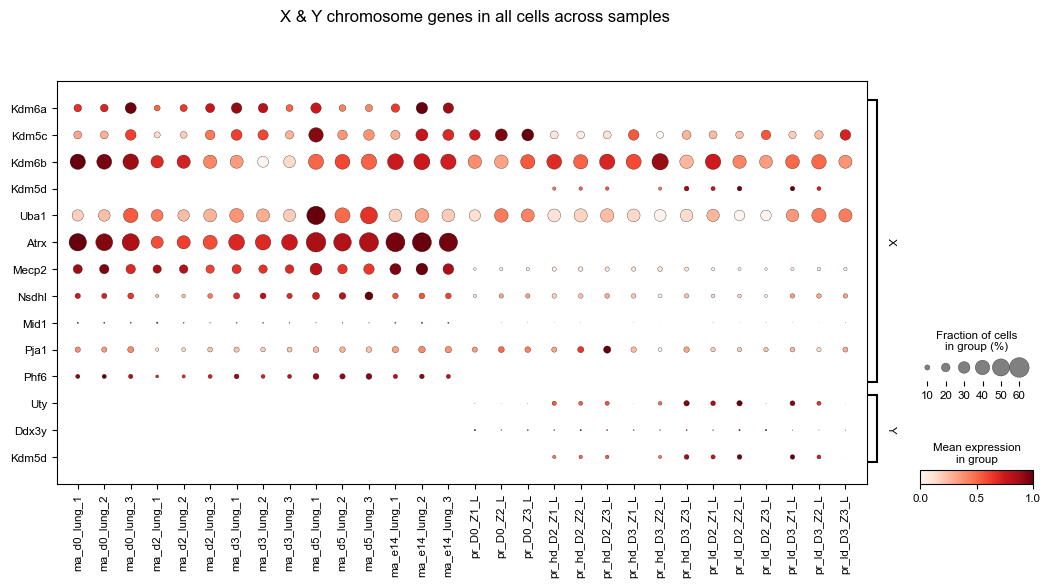

In [11]:

sc.pl.dotplot(superdata, 
              {'X': chr_x, 'Y': chr_y},
              groupby='orig.ident', use_raw=False, dendrogram=False, standard_scale='var',
              swap_axes=True, title='X & Y chromosome genes in all cells across samples')